# ResNet

In [2]:
pip install torch torchvision seaborn opencv-python-headless numpy matplotlib tqdm scikit-image

  Using cached torch-2.10.0-cp311-none-macosx_11_0_arm64.whl.metadata (31 kB)
  Using cached torchvision-0.25.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached filelock-3.20.3-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2026.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached markupsafe-3.0.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (2.7 kB)
Using cached torch-2.10.0-cp311-none-macosx_11_0_arm64.whl (79.4 MB)
Using cached torchvision-0.25.0-cp311-cp311-macosx_11_0_arm64.whl (1.9 MB)
Using cached fsspec-2026.1.0-py3-none-any.whl (201 kB)
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Using cached filelock-3.20.3-py3-none-any.whl (16 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
Using cached markupsafe-

## Data Loading

In [24]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import random

from skimage.feature import hog
from skimage import data, exposure

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image


import torch.nn as nn
from scipy.spatial.distance import euclidean

import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
import sklearn

In [4]:
data_root_path = "data/UCF-101"

# On a gardé au préalable uniquement les classes nous intéressant
CLASS_NAMES = sorted(os.listdir(data_root_path))
if '.DS_Store' in CLASS_NAMES :
    CLASS_NAMES.remove('.DS_Store')
NUM_CLASSES = len(CLASS_NAMES)
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 5


In [5]:
## Function to extract frames from a video file
def extract_all_frames_from_video(video_path, frame_rate=3):
    frames = []
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return frames

    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps / frame_rate)

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frames.append(frame)
        frame_count += 1

    cap.release()
    return frames

## Function to split the video into reference and test sets
def create_reference_and_test_path_sets(data_root_path, reference_ratio=0.75):
    reference_set = {}
    test_set = {}
    
    for class_name in CLASS_NAMES:
        class_path = os.path.join(data_root_path, class_name)
        video_files = [f for f in os.listdir(class_path) if f.endswith('.avi')]
        
        groups = set()
        for f in video_files:
            parts = f.split('_')
            for part in parts:
                if part.startswith('g') and len(part) == 3 and part[1:].isdigit():
                    groups.add(part)
        
        groups = list(groups)
        random.shuffle(groups)
        
        split_index = int(len(groups) * reference_ratio)
        ref_groups = set(groups[:split_index])
        test_groups = set(groups[split_index:])
        
        reference_set[class_name] = []
        test_set[class_name] = []
        
        for f in video_files:
            file_group = None
            parts = f.split('_')
            for part in parts:
                if part.startswith('g') and len(part) == 3 and part[1:].isdigit():
                    file_group = part
                    break
            
            full_path = os.path.join(class_path, f)
            
            if file_group in ref_groups:
                reference_set[class_name].append(full_path)
            elif file_group in test_groups:
                test_set[class_name].append(full_path)
                
    return reference_set, test_set

## Function to extract the frames from all videos in list of set video paths
def extract_frames_from_video_set(video_path_set, frame_rate=3):
    dataset_frames = {}
    for class_name, video_paths in tqdm(video_path_set.items(), desc="Processing classes"):
        dataset_frames[class_name] = []
        for video_path in tqdm(video_paths, desc=f"Processing videos in {class_name}", leave=False):
            frames = extract_all_frames_from_video(video_path, frame_rate)
            dataset_frames[class_name].extend(frames)
    return dataset_frames

In [6]:
reference_path_set, test_path_set = create_reference_and_test_path_sets(data_root_path, reference_ratio=0.75)
reference_frame_dataset = extract_frames_from_video_set(reference_path_set, frame_rate=1)
test_frame_dataset = extract_frames_from_video_set(test_path_set, frame_rate=1)

Processing classes: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


## ResNet Computation

In [7]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT, )
model.fc = nn.Identity()

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model.to(device)
model.eval()
preprocess = models.ResNet50_Weights.DEFAULT.transforms()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/homefolder/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:02<00:00, 48.1MB/s]


mps


In [8]:
def compute_resnet_features(train_set, model, preprocess):
    features = {}
    
    with torch.no_grad():
        for class_name, frames in tqdm(train_set.items(), desc="Computing ResNet Features"):
            features_list = []
            ## batch processing
            batch_size = 32
            batch = []
            for i, frame in enumerate(frames):
                # Preprocess the frame
                pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                input_tensor = preprocess(pil_image).unsqueeze(0).to(device)
                batch.append(input_tensor)

                # If batch is full or it's the last frame, process it
                if len(batch) == batch_size or i == len(frames) - 1:
                    # Process all frames in the batch
                    batch_tensor = torch.cat(batch, dim=0)
                    feature_vectors = model(batch_tensor).cpu().numpy()
                    features_list.extend(feature_vectors)
                    features[class_name] = [(fv, None) for fv in features_list]  # Store feature vector 
                    batch = []  # Reset batch for next iteration
                    
    return features

## Nearest Centroid

In [17]:
def calculs_centroides(features_dataset):
    centroids = {}
    for class_name, features in features_dataset.items():
        feature_vectors = [fv for fv, _ in features]
        centroids[class_name] = np.mean(feature_vectors, axis=0)
    return centroids

resnet_reference_features_dataset = compute_resnet_features(reference_frame_dataset, model, preprocess)
resnet_test_features_dataset = compute_resnet_features(test_frame_dataset, model, preprocess)

# On calcule les signatures moyennes
class_centroids = calculs_centroides(resnet_reference_features_dataset)

Computing ResNet Features: 100%|██████████| 5/5 [00:12<00:00,  2.41s/it]


                  precision    recall  f1-score   support

          Biking       0.98      0.98      0.98       304
HandstandPushups       0.87      0.91      0.89       151
    PlayingCello       1.00      0.97      0.99       492
   PlayingViolin       0.95      0.96      0.95       231
         PushUps       0.74      0.77      0.75       104

        accuracy                           0.95      1282
       macro avg       0.91      0.92      0.91      1282
    weighted avg       0.95      0.95      0.95      1282



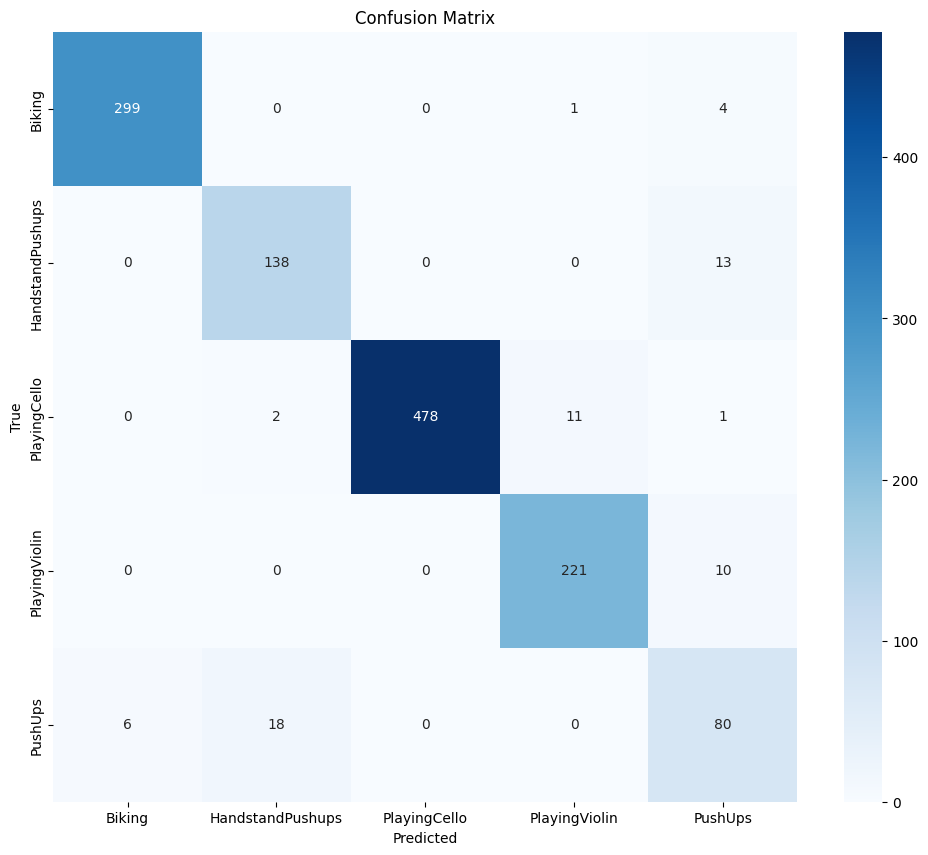

In [ ]:
def measure_distance(fd1, fd2):
    return np.linalg.norm(fd1 - fd2)

def classify_frame_hog(fd, class_hog_averages):
    min_distance = float('inf')
    predicted_class = None
    for class_name, average_fd in class_hog_averages.items():
        distance = measure_distance(fd, average_fd)
        if distance < min_distance:
            min_distance = distance
            predicted_class = class_name
    return predicted_class

def compute_centroid_hog_predictions(hog_features_dataset, class_hog_averages):
    predictions = {}
    for class_name, features in hog_features_dataset.items():
        predictions[class_name] = []
        for fd, hog_image in features:
            predicted_class = classify_frame_hog(fd, class_hog_averages)
            predictions[class_name].append(predicted_class)
    return predictions

def evaluate_classification(prediction):
    y_true = []
    y_pred = []
    for class_name, predicted_classes in prediction.items():
        y_true.extend([class_name] * len(predicted_classes))
        y_pred.extend(predicted_classes)

    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=CLASS_NAMES)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    
# Lancement de l'inférence
predictions_resnet_centroid = compute_centroid_hog_predictions(resnet_test_features_dataset, class_centroids)
evaluate_classification(predictions_resnet_centroid)

--- Global Performance ---
Accuracy:  0.9119
Precision: 0.9176
Recall:    0.9119
F1-Score:  0.9129



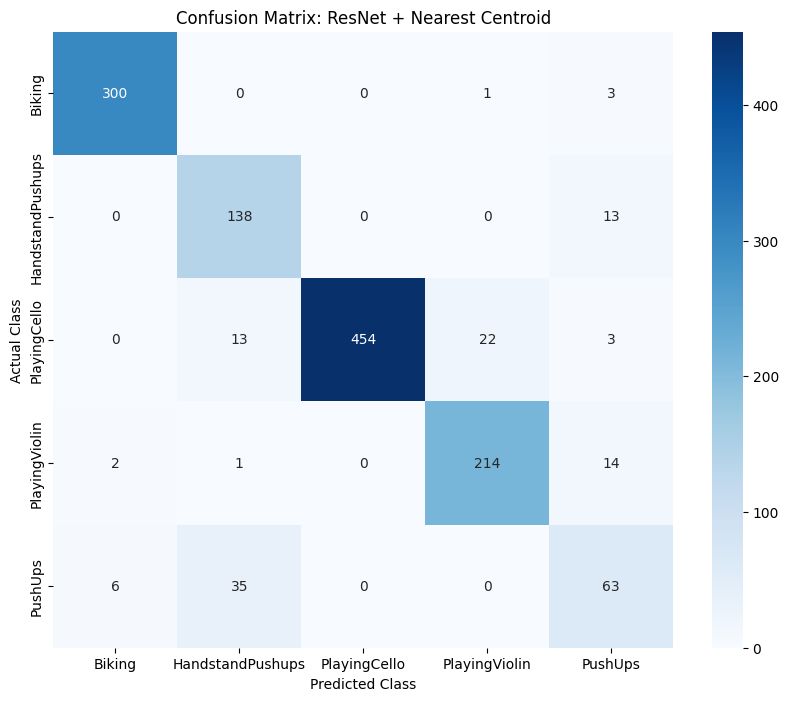

In [14]:
def display_metrics(y_true, y_pred, class_names):
    # 1. Calculate Metrics
    accuracy = accuracy_score(y_true, y_pred)
    # Using 'weighted' average to account for potential class imbalance
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"--- Global Performance ---")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}\n")

    # 2. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix: ResNet + Nearest Centroid')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

# Run the evaluation
display_metrics(y_true, y_pred, CLASS_NAMES)

## KNN

In [15]:
## Compute classification using k-NN approach
resnet_reference_features_dataset = resnet_reference_features_dataset
resnet_features_test_features_dataset = resnet_features_test_features_dataset

#print(resnet_features_test_features_dataset)
def find_k_closest_neighbors(fd, resnet_reference_features_dataset, k=5):
    distances = []
    for class_name, features in resnet_reference_features_dataset.items():
        #print("feat:", features)
        for ref_fd, _ in features:
            distance = np.linalg.norm(fd - ref_fd)
            distances.append((distance, class_name))
    distances.sort(key=lambda x: x[0])
    return distances[:k]

def majority_vote(neighbors):
    class_votes = {}
    for _, class_name in neighbors:
        if class_name in class_votes:
            class_votes[class_name] += 1
        else:
            class_votes[class_name] = 1
    sorted_votes = sorted(class_votes.items(), key=lambda x: x[1], reverse=True)
    return sorted_votes[0][0]

def classify_frame_knn(fd, resnet_reference_features_dataset, k=5):
    neighbors = find_k_closest_neighbors(fd, resnet_reference_features_dataset, k)
    predicted_class = majority_vote(neighbors)
    return predicted_class

def run_knn_classification(resnet_test_features_dataset, resnet_reference_features_dataset, k=5):
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for class_name, features in tqdm(resnet_test_features_dataset.items(), desc="k-NN Predicting"):
            for test_feature, _ in features:
                predicted_class = classify_frame_knn(test_feature, resnet_reference_features_dataset, k)
                
                y_true.append(class_name)
                y_pred.append(predicted_class)
                
    return y_true, y_pred

y_true_knn, y_pred_knn = run_knn_classification(resnet_features_test_features_dataset, resnet_reference_features_dataset, k=5)
print(classification_report(y_true_knn, y_pred_knn, target_names=CLASS_NAMES))

NameError: name 'resnet_reference_features_dataset' is not defined